# 같은 각도 같은 방향을 바라보고 있으면 깔끔하게 정합이 가능
1. rotate, flip, mirroring 순서를 어떻게 정할지에 대한 생각 해보기

In [1]:
import numpy as np
import cv2
import os
from utils.utils import *
import matplotlib.pyplot as plt
import numpy as np

data_dir = './result/'

imgs_list = []
for data in os.listdir(data_dir):
    if data[-4:] == ".jpg":
        img = cv2.imread(data_dir + data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_list.append(img)

def image_stitch(imgs1, imgs2):
    imgs = [imgs1, imgs2]
    stitcher = cv2.Stitcher_create()
    status, dst = stitcher.stitch(imgs)

    return status, dst


def find_direction(img1, img2):
    # SIFT 추출기 생성
    sift = cv2.SIFT_create()

    # ORB 추출기 생성
    # orb = cv2.ORB_create()

    # 특징점과 디스크립터 추출
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN 매처 생성
    flann = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': 5}, {'checks': 50})

    # 매칭 결과 추출
    matches = flann.knnMatch(des1, des2, k=2)

    # 좋은 매칭 결과 필터링
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    print("good matching len : ", len(good_matches))

    # 매칭 결과 시각화
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_matches)

    # 매칭된 특징점의 위치 추출
    points1 = np.array([kp1[m.queryIdx].pt for m in good_matches])
    points2 = np.array([kp2[m.trainIdx].pt for m in good_matches])

    # 호모그래피 계산
    H, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # 회전 각도 계산
    angle = np.rad2deg(np.arctan2(H[1, 0], H[0, 0]))

    return angle
    
    



good matching len :  34
-179.84232086821862


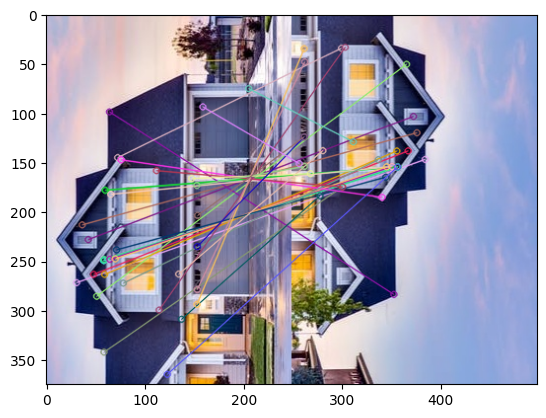

In [2]:
imgs1 = imgs_list[0]
imgs2 = imgs_list[1]
angle = find_direction(imgs1, imgs2)
print(angle)

In [3]:
def collect(imgs1, imgs2, angle):
    while True:
        if angle <= 5 and angle >= -5:
            break

        elif angle <= 95 and angle >= 85:
            imgs2 = rotate(imgs2)
            angle = find_direction(imgs1, imgs2)
        
        elif angle <= -85 and angle >= -95:
            imgs2 = rotate(mirroring(imgs2))
            angle = find_direction(imgs1, imgs2)
            
        elif angle <= 175 and angle >= 185:
            imgs2 = mirroring(imgs2)
            angle = find_direction(imgs1, imgs2)

    return imgs1, imgs2
        


In [ ]:
imgs1, imgs2 = collect(imgs1, imgs2, angle)

: 

: 

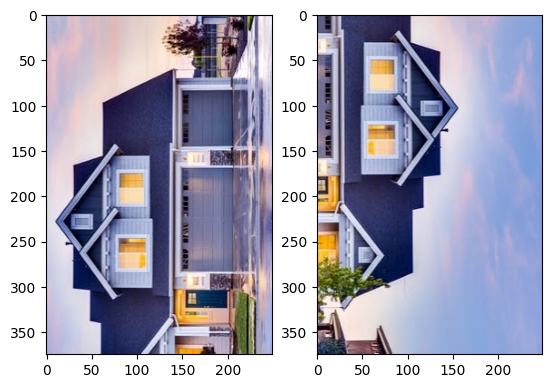

In [4]:
plt.subplot(1,2,1)
plt.imshow(imgs1)
plt.subplot(1,2,2)
plt.imshow(imgs2)

In [5]:
def merge_image(imgs1, imgs2):
    status, img_stitch = image_stitch(imgs1, imgs2)
    if status == 1:
        status, img_stitch = image_stitch(imgs1, flip(imgs2))

    return status, img_stitch

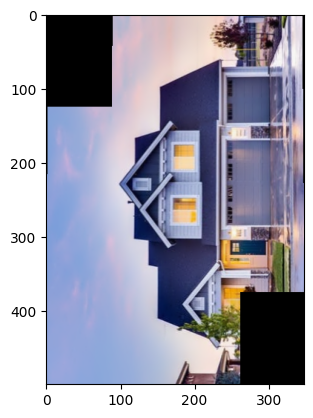

In [6]:
status, img_stitch = merge_image(imgs1, imgs2)
plt.imshow(img_stitch)

In [7]:
for i, k in enumerate(imgs_list):
    if i == 0:
        imgs1 = k
        continue

    imgs2 = k
    angle = find_direction(imgs1, imgs2)
    imgs1, imgs2 = collect(imgs1, imgs2, angle)
    status, img_stitch = merge_image(imgs1, imgs2)
    imgs1 = img_stitch

good matching len :  34


In [ ]:
plt.imshow(imgs1)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(imgs_list[0])
plt.subplot(1,2,2)
plt.imshow(imgs_list[1])

NameError: name 'plt' is not defined